In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/15 11:21:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/02/15 11:21:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


[wrangle.py] reading case.csv


[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features


[wrangle.py] joining departments



df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only show

In [2]:
df

DataFrame[case_id: int, case_opened_date: timestamp, case_closed_date: timestamp, case_due_date: timestamp, case_late: boolean, num_days_late: double, case_closed: boolean, service_request_type: string, SLA_days: double, case_status: string, source_id: string, request_address: string, council_district: string, num_weeks_late: double, zipcode: string, case_age: int, days_to_closed: int, case_lifetime: int, department: string, dept_subject_to_SLA: boolean]

In [3]:
sample = df.sample(fraction=0.01, seed=13).toPandas()

In [4]:
sample.head()

,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127339,2018-01-01 06:58:00,2018-01-02 15:32:00,2018-01-17 08:30:00,False,-14.706620,True,Front Or Side Yard Parking,16.063796,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.100946,78251,219,1.0,1,DSD/Code Enforcement,True
1,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.101896,78251,219,1.0,1,DSD/Code Enforcement,True
2,1014127446,2018-01-01 11:27:00,2018-01-03 17:08:00,2018-01-06 11:27:00,False,-2.763333,True,Aggressive Animal(Non-Critical),5.000000,Closed,139344,SAN FERNANDO and SAN HORACIO S,005,-0.394762,,219,2.0,2,Animal Care Services,True
3,1014127470,2018-01-01 12:33:00,2018-01-01 12:43:00,2020-09-26 12:33:00,False,-998.993079,True,Stray Animal,999.000000,Closed,139344,"159 SURFRIDER, San Antonio, 78242",004,-142.713297,78242,219,0.0,0,Animal Care Services,True
4,1014127599,2018-01-01 15:25:00,2018-01-03 05:52:00,2018-01-02 03:25:00,True,1.101817,True,Trapped/Confined Animal,0.500000,Closed,rs16746,"633 ST MARYS S, San Antonio, 78205",001,0.157402,78205,219,2.0,2,Animal Care Services,True


Explore the distribution of the case_lifetime feature:

<AxesSubplot:ylabel='Frequency'>

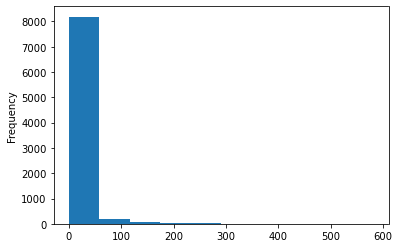

In [5]:
sample.case_lifetime.plot.hist()

[0, 1)        2539
[1, 2)        1649
[2, 5)        1453
[5, 15)       1449
[15, 1000)    1432
Name: case_lifetime, dtype: int64


Text(0.5, 1.0, 'Overall Case Lifetime')

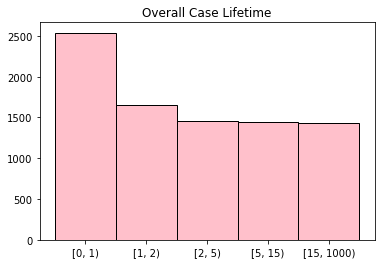

In [6]:
# In the call to `pd.cut`, we add right=False so that the behavior of pd.cut
# aligns with the behavior of np.histogram, which is what matplotlib uses when
# constructing a histogram.

# custom bins of varying widths
bins = [0, 1, 2, 5, 15, 1000]

print(
    pd.cut(sample.case_lifetime, bins, right=False).value_counts().sort_index()
)

pd.cut(
    sample.case_lifetime, bins, right=False
).value_counts().sort_index().plot.bar(
    width=1, edgecolor="black", color="pink"
)
plt.xticks(rotation=0)
plt.title("Overall Case Lifetime")

In [7]:
cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

cases_by_day.show(5)


+--------------------+----------------+----------------+
|          department|case_opened_date|case_closed_date|
+--------------------+----------------+----------------+
|Animal Care Services|      2018-01-01|      2018-01-01|
|Trans & Cap Impro...|      2018-01-01|      2018-01-03|
|Trans & Cap Impro...|      2018-01-01|      2018-01-02|
|DSD/Code Enforcement|      2018-01-01|      2018-01-02|
|Animal Care Services|      2018-01-01|      2018-01-01|
+--------------------+----------------+----------------+
only showing top 5 rows



# Exercises

In [9]:
# Check the shape of the dataset.
sample.shape

(8522, 20)

In [10]:
# Get familiar with the dataframe.
sample.head()

,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127339,2018-01-01 06:58:00,2018-01-02 15:32:00,2018-01-17 08:30:00,False,-14.706620,True,Front Or Side Yard Parking,16.063796,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.100946,78251,219,1.0,1,DSD/Code Enforcement,True
1,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.101896,78251,219,1.0,1,DSD/Code Enforcement,True
2,1014127446,2018-01-01 11:27:00,2018-01-03 17:08:00,2018-01-06 11:27:00,False,-2.763333,True,Aggressive Animal(Non-Critical),5.000000,Closed,139344,SAN FERNANDO and SAN HORACIO S,005,-0.394762,,219,2.0,2,Animal Care Services,True
3,1014127470,2018-01-01 12:33:00,2018-01-01 12:43:00,2020-09-26 12:33:00,False,-998.993079,True,Stray Animal,999.000000,Closed,139344,"159 SURFRIDER, San Antonio, 78242",004,-142.713297,78242,219,0.0,0,Animal Care Services,True
4,1014127599,2018-01-01 15:25:00,2018-01-03 05:52:00,2018-01-02 03:25:00,True,1.101817,True,Trapped/Confined Animal,0.500000,Closed,rs16746,"633 ST MARYS S, San Antonio, 78205",001,0.157402,78205,219,2.0,2,Animal Care Services,True


In [13]:
# Check data types and null values.
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8522 entries, 0 to 8521
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   case_id               8522 non-null   int32         
 1   case_opened_date      8522 non-null   datetime64[ns]
 2   case_closed_date      8326 non-null   datetime64[ns]
 3   case_due_date         8522 non-null   datetime64[ns]
 4   case_late             8522 non-null   bool          
 5   num_days_late         8522 non-null   float64       
 6   case_closed           8522 non-null   bool          
 7   service_request_type  8522 non-null   object        
 8   SLA_days              8522 non-null   float64       
 9   case_status           8522 non-null   object        
 10  source_id             8522 non-null   object        
 11  request_address       8522 non-null   object        
 12  council_district      8522 non-null   object        
 13  num_weeks_late    

In [17]:
# Drop null values.
sample.dropna(inplace=True)

In [30]:
sample.head()

,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
0,1014127339,2018-01-01 06:58:00,2018-01-02 15:32:00,2018-01-17 08:30:00,False,-14.706620,True,Front Or Side Yard Parking,16.063796,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.100946,78251,219,1.0,1,DSD/Code Enforcement,True
1,1014127368,2018-01-01 07:18:00,2018-01-02 15:22:00,2018-01-17 08:30:00,False,-14.713275,True,Right Of Way/Sidewalk Obstruction,16.049769,Closed,svcCRMSS,"10133 FIGARO CANYON, San Antonio, 78251",004,-2.101896,78251,219,1.0,1,DSD/Code Enforcement,True
2,1014127446,2018-01-01 11:27:00,2018-01-03 17:08:00,2018-01-06 11:27:00,False,-2.763333,True,Aggressive Animal(Non-Critical),5.000000,Closed,139344,SAN FERNANDO and SAN HORACIO S,005,-0.394762,,219,2.0,2,Animal Care Services,True
3,1014127470,2018-01-01 12:33:00,2018-01-01 12:43:00,2020-09-26 12:33:00,False,-998.993079,True,Stray Animal,999.000000,Closed,139344,"159 SURFRIDER, San Antonio, 78242",004,-142.713297,78242,219,0.0,0,Animal Care Services,True
4,1014127599,2018-01-01 15:25:00,2018-01-03 05:52:00,2018-01-02 03:25:00,True,1.101817,True,Trapped/Confined Animal,0.500000,Closed,rs16746,"633 ST MARYS S, San Antonio, 78205",001,0.157402,78205,219,2.0,2,Animal Care Services,True


### 1. How many different cases are there, by department?

In [22]:
sample.department.value_counts()

DSD/Code Enforcement        3135
Solid Waste                 2719
Animal Care Services        1200
Trans & Cap Improvements     999
Parks & Recreation           198
Metro Health                  52
Customer Service              23
Name: department, dtype: int64

### 2. Does the percentage of cases that are late vary by department?

In [24]:
late_cases = sample[sample.case_late == True]

In [34]:
late_cases

,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,source_id,request_address,council_district,num_weeks_late,zipcode,case_age,days_to_closed,case_lifetime,department,dept_subject_to_SLA
4,1014127599,2018-01-01 15:25:00,2018-01-03 05:52:00,2018-01-02 03:25:00,True,1.101817,True,Trapped/Confined Animal,0.500000,Closed,rs16746,"633 ST MARYS S, San Antonio, 78205",001,0.157402,78205,219,2.0,2,Animal Care Services,True
17,1014130563,2018-01-02 16:07:00,2018-02-27 10:32:00,2018-01-07 16:07:00,True,50.767535,True,Animal Neglect,5.000000,Closed,mc21309,"3102 MAYFAIR DR, San Antonio, 78217",010,7.252505,78217,218,56.0,56,Animal Care Services,True
24,1014132095,2018-01-03 11:00:00,2018-03-12 09:44:00,2018-01-08 11:00:00,True,62.947072,True,Animal Neglect,5.000000,Closed,ss09159,"1910 MAYFIELD W, San Antonio, 78211",004,8.992439,78211,217,68.0,68,Animal Care Services,True
25,1014132126,2018-01-03 11:05:00,2018-01-18 11:28:00,2018-01-08 11:05:00,True,10.016354,True,Aggressive Animal(Non-Critical),5.000000,Closed,mp21218,"305 PAUL ST, San Antonio, 78203",002,1.430908,78203,217,15.0,15,Animal Care Services,True
41,1014135882,2018-01-04 13:51:00,2018-01-22 08:00:00,2018-01-19 13:51:00,True,2.756111,True,Additional Garbage Container - with Fee,15.000000,Closed,svcCRMSS,"74 KNIGHTS PEAK, San Antonio, 78254",007,0.393730,78254,216,18.0,18,Solid Waste,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8411,1014105966,2017-12-19 14:43:00,2018-01-03 13:03:00,2017-12-24 14:43:00,True,9.931181,True,License Renewal Invoice,5.000000,Closed,ns16326,"9505 FREDSBG RD, San Antonio, 78240",008,1.418740,78240,232,15.0,15,Metro Health,True
8425,1014108513,2017-12-20 14:23:00,2017-12-22 09:29:00,2017-12-21 02:23:00,True,1.295972,True,Aggressive Animal(Critical),0.500000,Closed,140508,"838 KEATS, San Antonio, 78211",005,0.185139,78211,231,2.0,2,Animal Care Services,True
8462,1014115651,2017-12-23 21:33:00,2018-02-04 12:13:00,2017-12-28 21:33:00,True,37.611354,True,Animal Neglect,5.000000,Closed,120752,"1218 VICKERS AVE, San Antonio, 78211",005,5.373051,78211,228,43.0,43,Animal Care Services,True
8474,1014118817,2017-12-26 21:16:00,2017-12-27 09:28:00,2017-12-27 09:16:00,True,0.008692,True,Trapped/Confined Animal,0.500000,Closed,119555,"122 STONEWALL AVE, San Antonio, 78214",003,0.001242,78214,225,1.0,1,Animal Care Services,True


In [48]:
(sample.department == 'Solid Waste').sum()

2719

In [33]:
late_cases.department.value_counts()

Solid Waste                 310
DSD/Code Enforcement        246
Animal Care Services        236
Trans & Cap Improvements     47
Parks & Recreation           37
Customer Service             15
Metro Health                  4
Name: department, dtype: int64

In [36]:
late_cases.department.unique()

array(['Animal Care Services', 'Solid Waste', 'DSD/Code Enforcement',
       'Trans & Cap Improvements', 'Parks & Recreation',
       'Customer Service', 'Metro Health'], dtype=object)

In [41]:
(late_cases.department == 'Solid Waste').sum()

310

In [57]:
for dept in late_cases.department.unique():
    print(f'{dept}:', (late_cases.department == dept).sum(), '-> percentage of cases:', ((late_cases.department == dept).sum()/(sample.department == dept).sum()))


Animal Care Services: 236 -> percentage of cases: 0.19666666666666666
Solid Waste: 310 -> percentage of cases: 0.11401250459727841
DSD/Code Enforcement: 246 -> percentage of cases: 0.0784688995215311
Trans & Cap Improvements: 47 -> percentage of cases: 0.04704704704704705
Parks & Recreation: 37 -> percentage of cases: 0.18686868686868688
Customer Service: 15 -> percentage of cases: 0.6521739130434783
Metro Health: 4 -> percentage of cases: 0.07692307692307693


# Takeaways
* Customer Service cases have the highest percentage of cases that are late with ~65% of its cases being completed late.
* ~19% of Parks & Recreation cases are late.

### 3. On average, how late are the late cases by department?

In [68]:
late_cases.shape

(895, 20)

<AxesSubplot:>

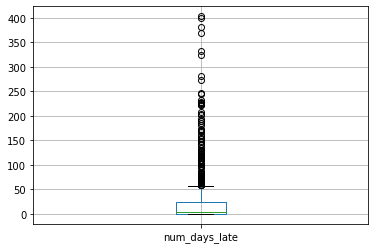

In [67]:
late_cases.boxplot(column='num_days_late')

In [64]:
late_cases.num_days_late.mean()

24.750423973296098

# Takeaways
* Late cases are late by ~25 days, on average.

#### What is the average after removing outliers?

In [ ]:
def remove_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr